# Garbage Classification with BERT and ResNet50
Lucas Rodrigues Valença, Matheus Marinho de Morais Leça

ENEL 645 - Fall 2024

### Installing required libraries

In [ ]:
!pip install torch torchvision transformers tqdm scikit-learn pandas pillow

In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision.models.resnet import resnet50
import os
import re
import random
import numpy as np
import json
from transformers import AutoTokenizer, AutoModel, AdamW, get_scheduler
from torch.utils.data import DataLoader
from tqdm import trange, tqdm
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
from PIL import Image, ImageDraw, ImageFont
from google.colab import drive
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from IPython.display import Image, display

drive.mount('/content/drive')

# Set GPU for training the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda


### Dataset loading and transformation techniques for image and texts

In [ ]:
# Set random seed for reproducibility
def set_seed(seed_val=42):
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_val)

set_seed()

# Constants and directories for saving data, results and predictions
IMAGE_FOLDER = "drive/MyDrive/en645/garbage_data"
RESULTS_FOLDER = "classification_results"
EXAMPLES_FOLDER = os.path.join(RESULTS_FOLDER, "example_predictions")
os.makedirs(RESULTS_FOLDER, exist_ok=True)
os.makedirs(EXAMPLES_FOLDER, exist_ok=True)
learning_rate = 5e-5
weight_decay = 0.01
warmup_steps = 0
num_train_epochs = 10
batch_size = 8
max_seq_length = 128
label_to_id = {'Black': 0, 'Blue': 1, 'Green': 2, 'TTR': 3}
id_to_label = {v: k for k, v in label_to_id.items()}

# Define image transformations for preprocessing. 224x224 is a standard dimension for images in several models and architectures
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
])

# Custom dataset class with the cleaned description based on file name
class ImageFolderWithFilenames(datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super().__getitem__(index)
        path, _ = self.samples[index]
        file_name = os.path.basename(path)
        text_description = re.sub(r'_\d+|\.png|\.jpg|\.jpeg', '', file_name).replace('_', ' ')
        return original_tuple + (text_description, path)



In [ ]:
# Load datasets for training, validation and test
# Each dataset applies the transformation
train_dataset = ImageFolderWithFilenames(root=os.path.join(IMAGE_FOLDER, 'CVPR_2024_dataset_Train'), transform=transform)
val_dataset = ImageFolderWithFilenames(root=os.path.join(IMAGE_FOLDER, 'CVPR_2024_dataset_Val'), transform=transform)
test_dataset = ImageFolderWithFilenames(root=os.path.join(IMAGE_FOLDER, 'CVPR_2024_dataset_Test'), transform=transform)

# Create the data loaders for batching and shuffling datasets
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


### Model definition and training

In [ ]:
# Define the Res-Net model
class ResNetFeatureModel(nn.Module):
    def __init__(self, output_layer='avgpool'):
        super().__init__()
        pretrained_resnet = resnet50(pretrained=True)
        layers = []
        for name, module in pretrained_resnet.named_children():
            layers.append(module)
            if name == output_layer:
                break
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        x = self.net(x)
        return torch.flatten(x, 1)

# Combine BERT (for text) and ResNet (for image)
class BertResNetModel(nn.Module):
    def __init__(self, num_labels, text_pretrained='bert-base-uncased'):
        super().__init__()
        self.text_encoder = AutoModel.from_pretrained(text_pretrained) # BERT model
        self.visual_encoder = ResNetFeatureModel(output_layer='avgpool') # ResNet model

        # Combine text and image features in a classifier layer
        text_hidden_size = self.text_encoder.config.hidden_size
        image_hidden_size = 2048
        self.classifier = nn.Linear(text_hidden_size + image_hidden_size, num_labels)

    # Process and concatenates text and image inputs, generating the logits scores
    def forward(self, text, image):
        text_output = self.text_encoder(**text).last_hidden_state[:, 0, :]
        img_feature = self.visual_encoder(image)
        features = torch.cat((text_output, img_feature), dim=1)
        logits = self.classifier(features)
        return logits

# Initialize components
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = BertResNetModel(num_labels=len(label_to_id)).to(device)

optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = get_scheduler("cosine", optimizer=optimizer, num_warmup_steps=warmup_steps, num_training_steps=len(train_dataloader) * num_train_epochs)
criterion = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler()

# Configure early stops parameter
early_stopping_patience = 5  # Number of epochs to wait for improvement
best_val_loss = float('inf')
early_stop_counter = 0

# Training loop with early stopping
for epoch_num in trange(num_train_epochs, desc='Epochs'):
    model.train()
    epoch_total_loss = 0 # Track training loss per epoch

    # Training phases
    for step, (b_imgs, b_labels, b_filenames, _) in tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc='Batch'):
        b_labels = b_labels.to(device)
        b_imgs = b_imgs.to(device)
        b_inputs = tokenizer(list(b_filenames), truncation=True, max_length=max_seq_length, return_tensors="pt", padding="max_length").to(device) # Tokenize filenames for BERT

        # Use mix precision to make training faster
        with torch.cuda.amp.autocast():
            b_logits = model(text=b_inputs, image=b_imgs)
            loss = criterion(b_logits, b_labels)

        # Accumulate loss, update gradients
        # Apply mixed precision, and adjust optimizer and scheduler
        epoch_total_loss += loss.item()
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

    # Validation phase
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for b_imgs, b_labels, b_filenames, _ in val_dataloader:
            b_labels = b_labels.to(device)
            b_imgs = b_imgs.to(device)
            b_inputs = tokenizer(list(b_filenames), truncation=True, max_length=max_seq_length, return_tensors="pt", padding="max_length").to(device)

            with torch.cuda.amp.autocast():
                b_logits = model(text=b_inputs, image=b_imgs)
                loss = criterion(b_logits, b_labels)
                val_loss += loss.item()

    # Calculate and log the average validation loss for epoch
    avg_val_loss = val_loss / len(val_dataloader)
    print(f'Epoch {epoch_num + 1} - Avg Training Loss: {epoch_total_loss / len(train_dataloader):.4f}, Validation Loss: {avg_val_loss:.4f}')

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stop_counter = 0
        print(f"Validation loss improved.")
    else:
        early_stop_counter += 1
        print(f"No improvement in validation loss. Early stopping counter: {early_stop_counter}/{early_stopping_patience}")

    if early_stop_counter >= early_stopping_patience:
        print("Early stopping triggered.")
        break


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 168MB/s]
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch imp

Epoch 1 - Avg Training Loss: 0.4006, Validation Loss: 0.4321
Validation loss improved.



Epochs:  20%|██        | 2/10 [1:03:56<3:44:52, 1686.52s/it]

Epoch 2 - Avg Training Loss: 0.2138, Validation Loss: 0.5342
No improvement in validation loss. Early stopping counter: 1/5



Epochs:  30%|███       | 3/10 [1:14:02<2:19:11, 1193.13s/it]

Epoch 3 - Avg Training Loss: 0.1307, Validation Loss: 0.5993
No improvement in validation loss. Early stopping counter: 2/5



Epochs:  40%|████      | 4/10 [1:24:09<1:36:10, 961.69s/it] 

Epoch 4 - Avg Training Loss: 0.0735, Validation Loss: 0.6575
No improvement in validation loss. Early stopping counter: 3/5



Epochs:  50%|█████     | 5/10 [1:34:14<1:09:25, 833.07s/it]

Epoch 5 - Avg Training Loss: 0.0369, Validation Loss: 0.7049
No improvement in validation loss. Early stopping counter: 4/5



Epochs:  50%|█████     | 5/10 [1:44:23<1:44:23, 1252.65s/it]

Epoch 6 - Avg Training Loss: 0.0206, Validation Loss: 0.6655
No improvement in validation loss. Early stopping counter: 5/5
Early stopping triggered.


### Prediction with comparison of results

In [ ]:
# Testing loop with example saving
model.eval()
predictions, true_labels, example_data = [], [], []

for b_imgs, b_labels, b_filenames, paths in tqdm(test_dataloader, desc='Testing'):
    b_labels = b_labels.to(device)
    b_imgs = b_imgs.to(device)
    b_inputs = tokenizer(list(b_filenames), truncation=True, max_length=max_seq_length, return_tensors="pt", padding="max_length").to(device)

    with torch.no_grad(), torch.cuda.amp.autocast():
        b_logits = model(text=b_inputs, image=b_imgs).cpu()

    pred_labels = torch.argmax(b_logits, dim=-1).tolist()
    true_labels.extend(b_labels.cpu().numpy())
    predictions.extend(pred_labels)

    # Collect examples data
    for pred, true, desc, img_path in zip(pred_labels, b_labels.cpu().tolist(), b_filenames, paths):
        example_data.append({
            "image_path": img_path,
            "description": desc,
            "true_class": id_to_label[true],
            "predicted_class": id_to_label[pred]
        })

# Create a composite image grid with annotations
def create_image_grid(sampled_examples, save_path):
    # Ensure the directory exists
    folder = os.path.dirname(save_path)
    if not os.path.exists(folder):
        os.makedirs(folder)

    try:
        font = ImageFont.truetype("arial.ttf", 15)
    except IOError:
        font = ImageFont.load_default()

    images = [Image.open(example["image_path"]).resize((224, 224)) for example in sampled_examples]
    total_width = sum(img.width for img in images)
    max_height = max(img.height for img in images) + 50  # Extra space for text

    composite_image = Image.new("RGB", (total_width, max_height), "white")
    draw = ImageDraw.Draw(composite_image)

    x_offset = 0
    for img, example in zip(images, sampled_examples):
        composite_image.paste(img, (x_offset, 0))

        text = (
            f"True Class: {example['true_class']}\n"
            f"Predicted: {example['predicted_class']}\n"
            f"Description: {example['description']}"
        )

        text_position = (x_offset, img.height + 5)
        draw.multiline_text(text_position, text, fill="black", font=font, spacing=4)

        x_offset += img.width

    composite_image.save(save_path)
    print(f"Composite image saved at {save_path}")

# Randomly sample up 3 examples from the collected data for visualization
sampled_examples = random.sample(example_data, min(3, len(example_data)))
create_image_grid(sampled_examples, os.path.join(EXAMPLES_FOLDER, 'example_predictions_composite.png'))


Testing:   0%|          | 0/429 [00:00<?, ?it/s]<ipython-input-15-24c22ae8abc6>:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():
Testing: 100%|██████████| 429/429 [22:07<00:00,  3.09s/it]


Composite image saved at classification_results/example_predictions/example_predictions_composite.png


### Metrics for evaluating the model performance

In [ ]:
# Calculate and display classification metrics and confusion matrix
prediction_labels = [id_to_label[p] for p in predictions]
true_labels_mapped = [id_to_label[t] for t in true_labels]
class_report = classification_report(true_labels_mapped, prediction_labels, output_dict=True)

# Convert classification report to a DataFrame for terminal display
metrics_df = pd.DataFrame(class_report).transpose()
metrics_df.index.name = 'Class'
metrics_df = metrics_df.rename(columns={'precision': 'Precision', 'recall': 'Recall', 'f1-score': 'F1 Score', 'support': 'Support'})
print("\nClassification Metrics:")
print(metrics_df)


Classification Metrics:
              Precision    Recall  F1 Score      Support
Class                                                   
Black          0.763819  0.656115  0.705882   695.000000
Blue           0.831169  0.825806  0.828479  1085.000000
Green          0.812102  0.957447  0.878805   799.000000
TTR            0.847666  0.809859  0.828331   852.000000
accuracy       0.818129  0.818129  0.818129     0.818129
macro avg      0.813689  0.812307  0.810374  3431.000000
weighted avg   0.817183  0.818129  0.815328  3431.000000


In [ ]:
# Display overall accuracy separately
overall_accuracy = class_report['accuracy']
print(f"\nOverall Accuracy: {overall_accuracy:.2f}")

# Confusion matrix as a DataFrame
cm = confusion_matrix(true_labels, predictions)
cm_df = pd.DataFrame(cm, index=label_to_id.keys(), columns=label_to_id.keys())
print("\nConfusion Matrix:")
print(cm_df)



Overall Accuracy: 0.82

Confusion Matrix:
       Black  Blue  Green  TTR
Black    456   100     61   78
Blue      71   896     77   41
Green     15    14    765    5
TTR       55    68     39  690


In [ ]:
# Save classification report to JSON for record-keeping
with open(os.path.join(RESULTS_FOLDER, 'resnet_class_report.json'), 'w') as f:
    json.dump(class_report, f)

# Optionally save the confusion matrix as a CSV file for further analysis
cm_df.to_csv(os.path.join(RESULTS_FOLDER, 'confusion_matrix.csv'))
print("Classification metrics, confusion matrix, and example predictions saved successfully.")


Classification metrics, confusion matrix, and example predictions saved successfully.


Confusion matrix image saved at classification_results/confusion_matrix_image.png


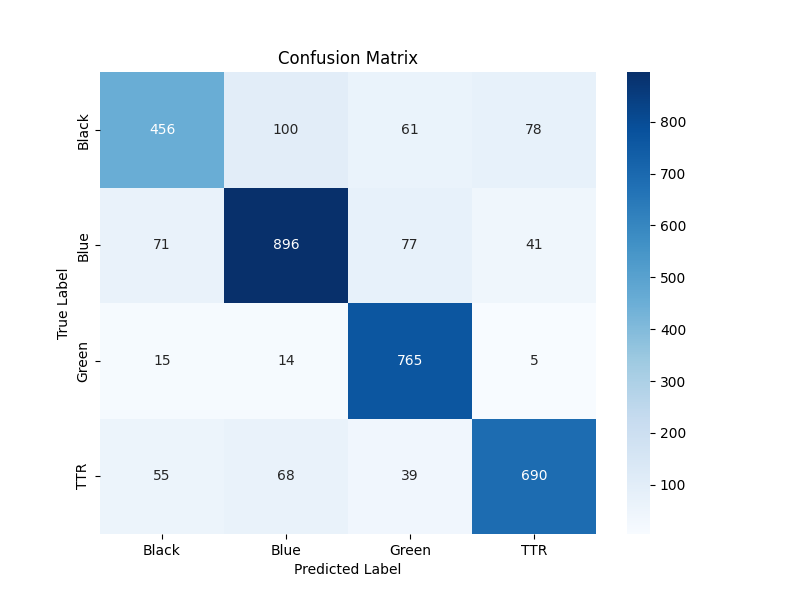

In [ ]:
def generate_confusion_matrix_image(csv_path, save_path, title="Confusion Matrix"):
    # Ensure the output directory exists
    folder = os.path.dirname(save_path)
    if folder and not os.path.exists(folder):
        os.makedirs(folder)

    # Load confusion matrix data from CSV
    cm_df = pd.read_csv(csv_path, index_col=0)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", cbar=True,
                xticklabels=cm_df.columns, yticklabels=cm_df.index)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)

    # Save the plot as an image
    plt.savefig(save_path)
    plt.close()
    print(f"Confusion matrix image saved at {save_path}")

    # Display the saved image in the notebook
    display(Image(filename=save_path))

# Example usage
generate_confusion_matrix_image("classification_results/confusion_matrix.csv", "classification_results/confusion_matrix_image.png")


### Display some of the classification results

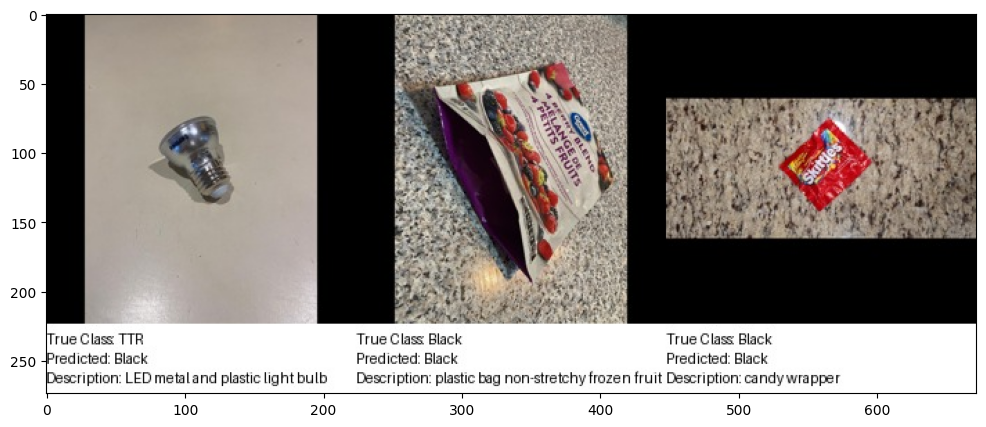

In [ ]:

RESULT_EXAMPLE_PATH = "drive/MyDrive/example_results.jpg"
result_example_image = mpimg.imread(RESULT_EXAMPLE_PATH)
plt.figure(figsize=(12, 6))
plt.imshow(result_example_image)
plt.show()